Todo: 
- Add a downscaled version of the dog/cat dataset instead of mnist; have faces and cifar 10 also. Maybe have a data class created in the start one can select from. 
- Change each use of neural networks to MLP?

# Generative Adversarial Networks and Variational AutoEncoders
Talk held 2. november at the MADALGO reading group. The talk will cover the following topics

<ol>
<li><b>Neural Networks</b>: Supervised Learning, Forward Pass, Back Propagation and Gradient Descent.</li>
<li><b>Discriminative vs. Generative Models</b>
<ul>
<li style="margin-top: -12px;">Variational AutoEncoders</li>
<li>Generative Adversarial Networks</li>
</ul></li>
<li><b>Open Problems</b></li>
</ol>

The following apetizer shows what you will be able to do after this tutorial.  

In [ ]:
# Put VAE and GAN's in a class that contains pretrained for several different datasets: MNIST, dogs vs cat, CIFAR10, etc 

#vae.generate(image, (4,4))
#gan.generate(image, (4,4))

#feed_forward.classify(vae_img)
#feed_forward.classify(gan_img)

# Neural Networks
## Supervised Learning
Consider a function $f:X\rightarrow Y$ that is unkown to us. Our goal will be to approximate this function. To this end, we have data on the form $D=\{(x_1, y_1), ..., (x_n, y_n)\}$ where $x\in X$ and $f(x_i)=y_i\in Y$. It is natural to ask "how good" a function $h: X\rightarrow Y$ is at approximating $f$. To this end one could be inclined to define error as  

$$ E_{in}(h)=\sum_{(x,y)\in D} \mathbb{1}_{h(x)=y}$$

Finding a function $h$ that approximates $f$ then becomes an optimization problem. There is one problem with this approach. One could design a function $h$ that remembers all the points and thus gets $E_{in}(h)=0$. Our goal is to approximate $f$ on all of $X$ and not just in $D$, so this is not what we want. 

If the data sample $D$ is chosen adversarially we are out of luck. An adversary could choose the same $(x_i, y_i)$ $N$ times, and it would be impossible to say something that we would be sure works on all of $X$. To handle this problem we assume the data is i.i.d. for some joint probability distribution $P(x,y)$. The goal now becomes to minimize the expected error under the joint probability distribution

$$ E_{out}(h) = \mathbb{E}[ \mathbb{1}_{h(x)\neq y}]$$

Unfortunately we have no way of computing $E_{out}$, in particular, we have no way of minimizing $E_{out}$. The approach we take is to minimize $E_{in}$ subject to some constraints that imply $Pr[|E_{in}-E_{out}|<\epsilon]$ is sufficiently small. In this case we say the hypothesis generalizes to outside the training data. 

One bounds the probability of $|E_{in}-E_{out}|$ using VC dimension. This is called Probably Approximately Correct Learning, or PAC learning for short, we shall not discuss it further here.  

## Feed Forward Neural Networks
The following figure represents a simple feed forward neural network

<img src="fig/feed_forward_neural_net.png" style="width: 600px; height: auto;" />

The network has three different types of layers: input, hidden and output layers. In the above example, the input layer has $d$ neurons, there are $h$ hidden neurons and $k$ output neurons. Each edge has an associated weight. Typically one represents the weights as $W_1\in \mathbb{R}^{d\times h}$, $W_2\in \mathbb{R}^{h \times k}, b_1\in \mathbb{R}^h$ and $b_2\in\mathbb{R}^k$. Given some input $x\in \mathbb{R}^d$ the output of the network is given

$$ NN(x)=\sigma( x W_1 + b_1)W_2 +b_2\quad\text{where}\quad\sigma(s)=\frac{1}{1+e^{-s}}$$

It is now possible for us to define an error for our neural network. 

$$ E_{in}=\sum_{i=1}^n (NN(x_i)-y_i)^2$$

The weights of our Neural Network will be initialized random, so as you would expect, the error will initially be terrible. Consider now the optimization problem 

$$ \text{min}_{W_1, W_2, b_1, b_2} \sum_{i=1}^N (NN(x_i-y_i)^2$$

To find sufficiently good weights one uses the backpropagation algorithm. The idea is to compute the derivative of the error $(NN(x)-y)^2$ with respect to the weights

$$ \frac{de}{dw}=\frac{d (NN(x)-y)^2}{dw}$$

It is now possible to take small steps in the direction of the negative gradient. This is called Gradient Descent. For convex functions Gradient Descent will eventually converge, but Neural Networks are highly non-convex, so we have no guarantees. The gradients are efficiently computed using backpropagation.  

<div style="border: 1px solid black; margin: 16px; padding: 16px;">
<b>Example:</b> Consider the following Feed Forward Neural Network <br><br>
$$ NN(x)=\text{relu}(x_1w_1+x_2w_2 +b_1)w_2+b_2$$<br>
It is now possible to compute<br><br>
$$ \frac{de}{dw_1}=\frac{d (NN(x)-y)^2}{dw_1}=...$$<br>
If you did not see neural networks before, it is a good exercise to consider the above network and compute the derivatives for say $w_1=1, w_2=2, x_1=....$<br>

</div>

In TensorFlow we have automated differentiation which handles backpropagation automatically. The only thing we need to specify is the cost function. This makes everything a lot easier. The following code is a simple Feed Forward Neural Network

In [ ]:
# Interactive Plotting
%matplotlib notebook 

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/", one_hot=True)

# Network architecture
d = 784
h = 256
k = 10

batch_size = 128
test_size = 256
train_steps = 5000
print_each = 64

X = tf.placeholder("float", shape=[None, d])
y = tf.placeholder("float", shape=[None, k])

init = tf.contrib.layers.xavier_initializer()

w1 = tf.Variable(init([d, h]))
w2 = tf.Variable(init([h, k]))
b1 = tf.zeros([h])
b2 = tf.zeros([k])

nn = tf.sigmoid(tf.matmul(tf.nn.sigmoid(tf.matmul(X, w1) + b1),w2) + b2)

loss = tf.reduce_mean( tf.pow( nn - y, 2 ) )
step = tf.train.AdamOptimizer(0.01).minimize(loss) 

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(nn,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# plotting
loss_vals_in = []
loss_vals_test = []
acc_in = []
acc_test = []

fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(9,4)) 
fig.tight_layout()
ax_loss.set_xlim(0, train_steps // print_each)
ax_loss.set_ylim(0, 0.1)
ax_acc.set_xlim(0, train_steps // print_each)
ax_acc.set_ylim(0, 1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(train_steps): 
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        sess.run([step], feed_dict={X: batch_xs, y: batch_ys})
        
        if i % 64 == 0: 
            
            current_loss_in, current_acc_in  = sess.run([loss, accuracy], feed_dict={X: batch_xs, y: batch_ys})
            current_loss_test, current_acc_test = sess.run([loss, accuracy], feed_dict={X: mnist.test.images[:test_size], y: mnist.test.labels[:test_size]}) 

            loss_vals_in.append(current_loss_in)
            loss_vals_test.append(current_loss_test)
            acc_in.append(1-current_acc_in)
            acc_test.append(1-current_acc_test)

            sys.stdout.write("\rStep: %i\tLoss: %f / %f \t0-1 error: %f / %f " % (i, current_loss_in, current_loss_test, current_acc_in, current_acc_test))
            sys.stdout.flush()
            
            ax_loss.plot(loss_vals_in, color='b')
            ax_loss.plot(loss_vals_test, color='g')
            
            ax_acc.plot(acc_in, color='b')
            ax_acc.plot(acc_test, color='g')
          
            fig.canvas.draw()  

# Discriminative vs. Generative
In the above model we were able to discriminate between classes. Generative models are models that allow us to generate data. This is possible in both a supervised and an unsupervised setting. There are several different generative models. In this talk I shall limit myself to consider the following two: 

1. Variational AutoEncoders [1,2,3] (https://arxiv.org/pdf/1312.6114.pdf
http://kvfrans.com/variational-autoencoders-explained/)
https://arxiv.org/pdf/1606.05908.pdf

2. Generative Adversarial Networks [1]

Both models are relatively new, VAE's are from 2013 and GAN's are from 2014. The models are all relatively new, so it seems there are a lot of open problems in this areas. There is definitely a lot of things that we do not understand yet. Furthermore, in practice there have been several nice applications of these models, including drug discovery [1], image compression [2], .....  

## Variational AutoEncoders
Before understanding Variational AutoEncoders we must consider AutoEncoders. Given data $D=\{x_1,...,x_n\}$ with $x_i\in\mathbb{R}^d$. Consider a simple feed forward neural network with $h<<d$ hidden neurons. Define the in-sample error to be $NN(x)-x)^2$. This corresponds to asking the Neural Network to learn the identity function. Because the middel layer contains less neurons than the input, we are forcing the neural network to find a low-dimensional encoding of the data. 

In this way we can think of the first part of the resulting neural network as an encoder, and the last part of the network as a decoder!

The following model trains a simple AutoEncoder

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


<IPython.core.display.Javascript object>


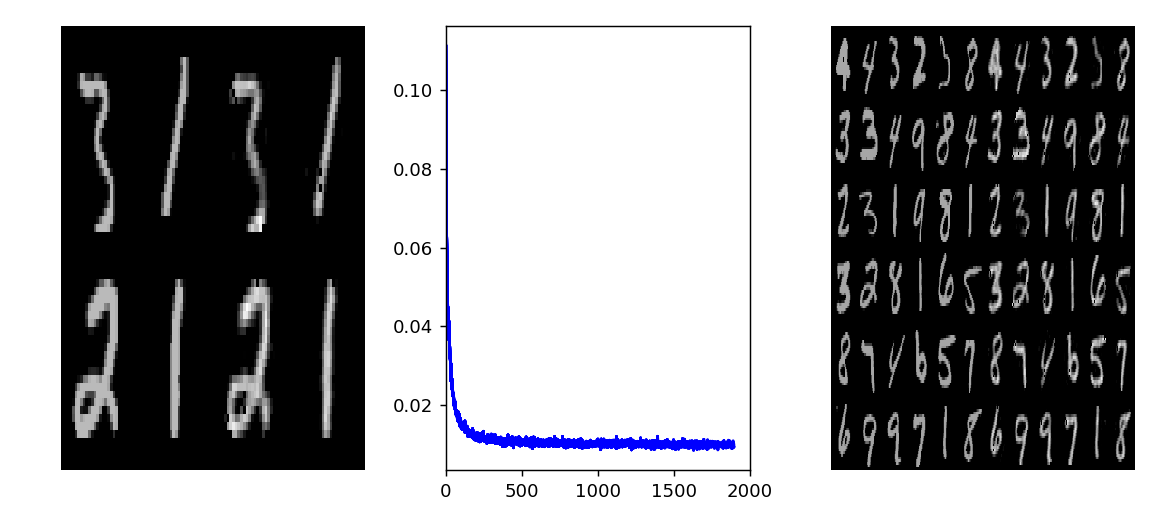

Step: 1900	Loss: 0.006271

In [5]:
# Interactive Plotting
%matplotlib notebook 

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

# Name for saving autoEncoder model with timestamp
model_name_autoenc     = "models/auto_enc25.ckpt"

# Import MNIST
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/")

# Training Constants
learning_rate = 0.005
batch_size = 128
train_steps = 2000

# Architecture
d = 28**2
h = 100

X = tf.placeholder("float", [None, d])
L = tf.placeholder("float", [None, h])

var_init = tf.contrib.layers.xavier_initializer()

w_enc = tf.Variable(var_init( [d, h] ))
b_enc = tf.Variable(var_init( [h] ))
w_dec = tf.Variable(var_init( [h, d] ))
b_dec = tf.Variable(var_init( [d] ))

enc_X = tf.nn.relu(tf.matmul(X, w_enc) + b_enc)
dec_X = tf.nn.relu(tf.matmul(enc_X, w_dec) + b_dec)

dec = tf.nn.relu(tf.matmul(L, w_dec) + b_dec) # for use to later decoding latent codes. 

loss = tf.reduce_mean(tf.pow( X - dec_X, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

saver = tf.train.Saver()

init = tf.global_variables_initializer()

# initialize interactive plotting
fig, (ax_train, ax_score, ax_done) = plt.subplots(1, 3, figsize=(9,4)) 
fig.tight_layout()
ax_train.axis("off")
ax_done.axis("off")
ax_score.set_xlim(0, train_steps)
visualize, _ = mnist.test.next_batch(4) 
loss_vals = []

with tf.Session() as sess:
    sess.run(init)
    
    for i in range(1, train_steps):
        
        batch, _ = mnist.train.next_batch(batch_size)
        _, current_loss = sess.run([optimizer, loss], feed_dict={X: batch})
        loss_vals.append(current_loss)
        
        # Visualize cool stuff
        if i % 100 == 0 or i == 1:  
            
            ax_score.plot(loss_vals, color='b')
            fig.canvas.draw()  
            
            pred, current_loss = sess.run([dec_X, loss], feed_dict={X: visualize})
            
            sys.stdout.write("\rStep: %i\tLoss: %f" % (i, current_loss))
            sys.stdout.flush() 
            
            images = np.empty((28 * 2, 28 * 2 * 2)) # add 2px space in between?
    
            for i in range(2):
                for j in range(2):
                    current_image = j + i*2

                    real_image = visualize[current_image].reshape([28, 28])
                    reconstructed_image = pred[current_image].reshape([28, 28])

                    # Add original image
                    images[i * 28: (i + 1) * 28, j * 28:(j + 1) * 28] = real_image

                    # Add reconstructed image
                    images[i * 28: (i + 1) * 28, j * 28+ 28*2:(j + 1) * 28+28*2] = reconstructed_image

            ax_train.imshow(images, origin="upper", cmap="gray", aspect='auto')
            fig.canvas.draw()      
            
    # save model
    saver.save(sess, model_name_autoenc)
        
    # print real images vs reconstructed images
    batch, _ = mnist.test.next_batch(100) # !! NOTICE WE TAKE TEST DIGITS TO ENSURE NOT OVERFIT!
    pred = sess.run(dec_X, feed_dict={X: batch})
    
    c = 6 
    images = np.empty((28 * c, 28 * c * 2)) # add 2px space in between?
    
    for i in range(c):
        for j in range(c):
            current_image = j + i*c
            
            real_image = batch[current_image].reshape([28, 28])
            reconstructed_image = pred[current_image].reshape([28, 28])
            
            # Add original image
            images[i * 28: (i + 1) * 28, j * 28:(j + 1) * 28] = real_image
                
            # Add reconstructed image
            images[i * 28: (i + 1) * 28, j * 28+ 28*c:(j + 1) * 28+28*c] = reconstructed_image

      
ax_done.imshow(images, origin="upper", cmap="gray", aspect='auto')
fig.canvas.show()

It is now possible to encode our data in a low dimensional space. Using the decoding part of the network we can reconstruct the data with small loss. Could we use this to generate data somehow? One idea would be to sample random points from the low dimensional space, and see what the decoder gives us: 

<IPython.core.display.Javascript object>


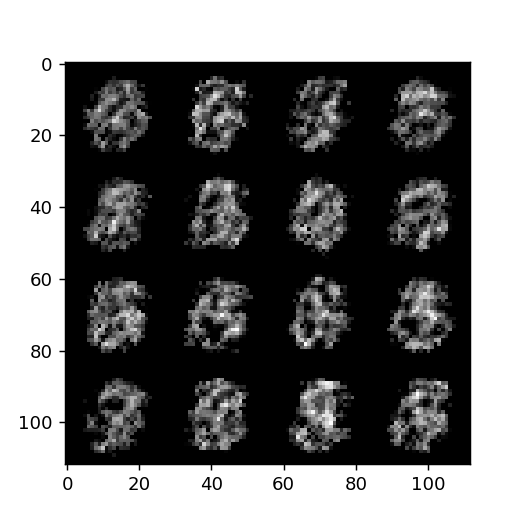

INFO:tensorflow:Restoring parameters from models/auto_enc25.ckpt
Model restored.
0.686977 0.523771
Step: 9

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4,4)) 

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, model_name_autoenc)
    print("Model restored.")
    
    enc = sess.run(enc_X, feed_dict={X: mnist.train.images[:100]})
    print(np.mean(enc), np.var(enc))
    l_space = np.random.normal(np.mean(enc), np.var(enc), (100, 100))
    
    for i in range(10):
        sys.stdout.write("\rStep: %i" % (i))
        sys.stdout.flush() 
        
        generated_images = sess.run(dec, feed_dict={L: l_space})

        c = 4
        images = np.empty((28 * c, 28 * c)) # add 2px space in between?

        for i in range(c):
            for j in range(c):
                current_image = generated_images[j + i*c]

                images[i * 28: (i + 1) * 28, j * 28:(j + 1) * 28] = current_image.reshape(28, 28)

        ax.imshow(images, origin="upper", cmap="gray", aspect='auto')
        fig.canvas.draw() 
        
        l_space = np.random.normal(np.mean(enc), np.var(enc), (100, 100))
        time.sleep(0.5)
        
    

That idea did not really work out that well. The output is very noisy. One possible explanation is that the encoded data is not evenly distributed in the low dimensional space. The low dimensional space is very sparse. Thus, random vectors in this low dimensional space are very unlikely to follow the encoded data distribubtion (the distribution of data points in the low dimensional space). 

There are two perspectives on Variational AutoEncoders [..]. One from the deep learning community and one from the statistical machine learning community. The latter has a nice mathematical justification for what we do, while the deep learning perspective seems conceptually different; at least if one is familiar with AutoEncoders. In this note we limit ourselves to the deep learning perspective. 

The idea is to force the distribution of the latent space to behave like a distribution we choose. Usually we use standard normal distributions. It is then trivial to sample from the latent space, because we forced it to behave like a gaussian. See the following for a visualization

<img src="http://kvfrans.com/content/images/2016/08/vae.jpg" style="width: 600px; height: auto;"/>

The encoder is changed to output distributions instead of vectors. This is done by making the encoder output vectors $\mu,\sigma^2\in \mathbb{R}^h$ that contain the mean and variance of $h$ normal distributions. Different samples of this distribution is then feed the decoder which attempts to minimize reconstruction error like a normal autoencoder. 

It is now left to measure how well the encoder fits a normal distribution. Ideally, we could measure the $D_{kl}$ divergence between a real normal distribution and what ..., but -0.5 $*$ tf.reduce_sum(1+z_stddev - tf.square(z_mean) - tf.exp(z_stddev), 1), lowerbound, ..?

The following code implements a very simple VAE. To allow ourselves to draw the low dimensional space, we will constrain the network to reduce dimensionality to 2 dimensions! This will obviously caused the constructed images to look a bit worse than the previous autoencoder. 

<IPython.core.display.Javascript object>


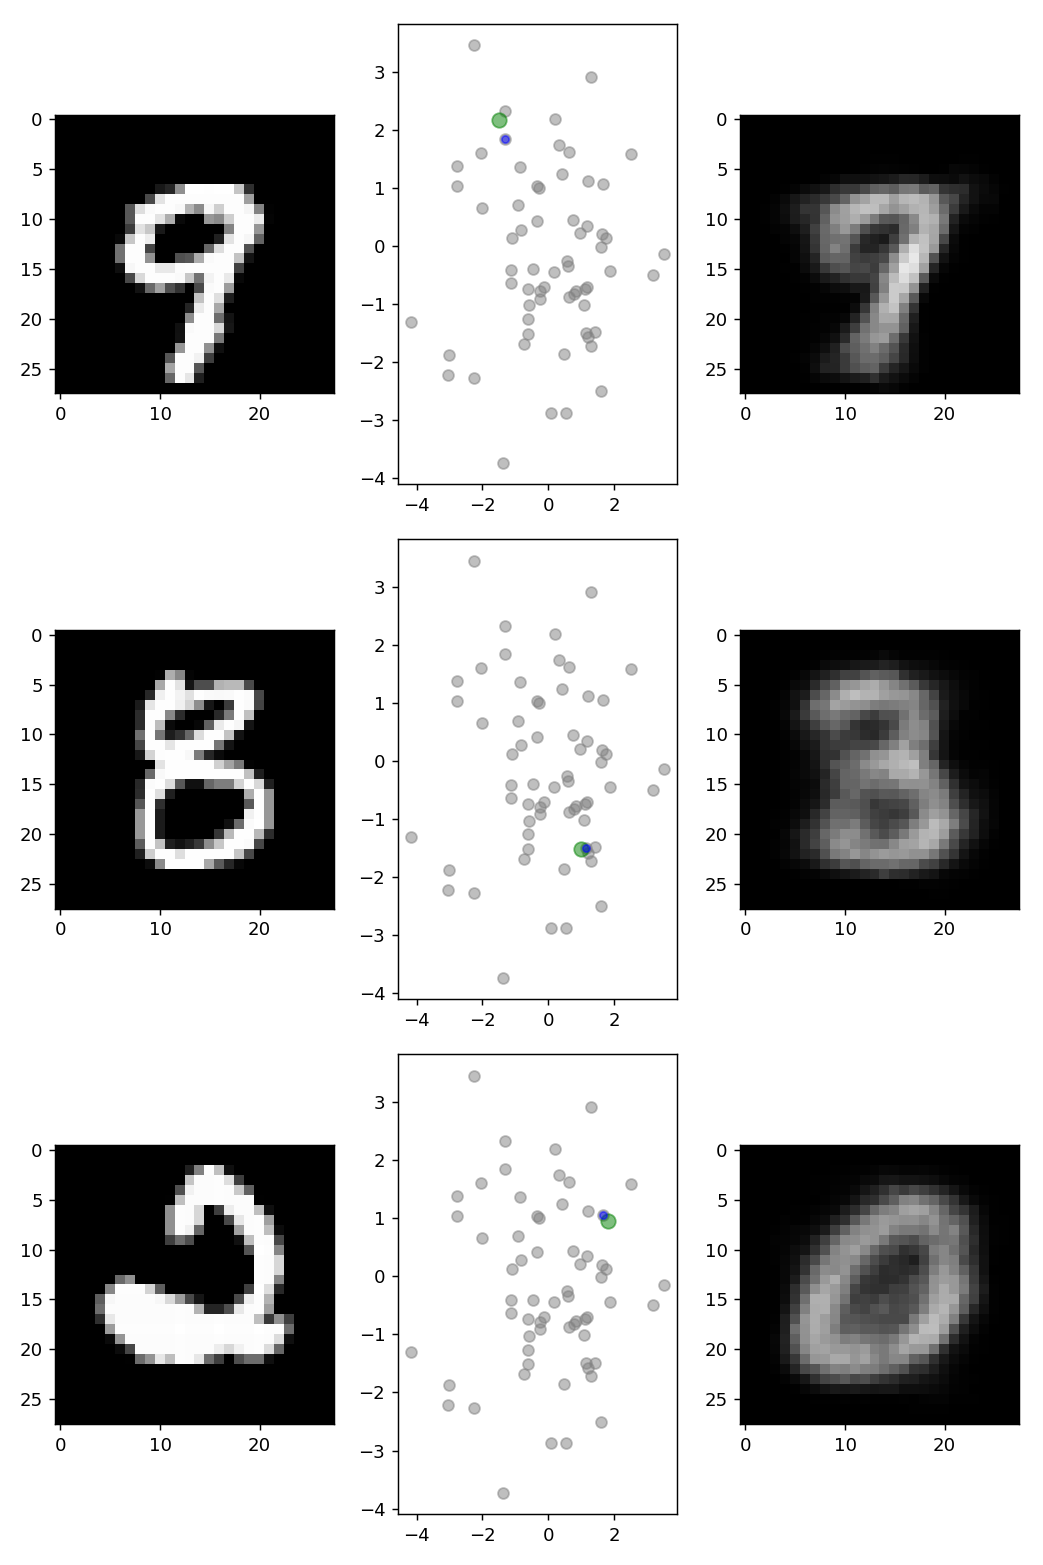

Model saved: model/vae2.ckpt	Epoch: 0010	Cost: 173.162321

In [8]:
# Based on https://github.com/oduerr/dl_tutorial/blob/master/tensorflow/vae/vae_demo.ipynb
x = tf.placeholder("float", shape=[None, 28*28])

batch_size = 64
n_samples = 5000

n_z = 2

def weight(shape): return tf.Variable(tf.truncated_normal(shape, stddev=0.1))
def bias(shape): return tf.Variable(tf.constant(0.1, shape=shape))
def log(x): return tf.log(1e-10 + x)  # numerical stable, don't log(0)

# encoder ;; softplus(x)=log(1+e^x) (relu approximates this)
W_enc1 = weight([784, 500])
b_enc1 = bias([500])
h1 = tf.nn.softplus(tf.matmul(x, W_enc1) + b_enc1)

W_enc2 = weight([500, 501])
b_enc2 = bias([501])
h2 = tf.nn.softplus(tf.matmul(h1, W_enc2) + b_enc2)

W_mean = weight([501, n_z])
b_mean = bias([n_z])
W_stddev = weight([501, n_z])
b_stddev = bias([n_z])

# random vars
z_mean   = tf.matmul(h2, W_mean)   + b_mean
z_stddev = tf.matmul(h2, W_stddev) + b_stddev

# we will sample from these and add them to the decoder
# decoder
#eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32) # Adding a random number
#z   = tf.add(z_mean, tf.matmul(tf.sqrt(tf.exp(z_stddev)), eps))   # The sampled z
#z = tf.random_normal((batch_size, n_z), z_mean, z_stddev)
eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32)
        # z = mu + sigma*epsilon
t = tf.multiply(tf.sqrt(tf.exp(z_stddev)), eps)
z = tf.add(z_mean, t) #why z_log_sigma_sq
#z = z_mean + z_stddev * eps

W_dec1 = weight([n_z, 500])
b_dec1 = bias([500])
d1 = tf.nn.softplus(tf.matmul(z, W_dec1) + b_dec1)

W_dec2 = weight([500, 500])
b_dec2 = weight([500])
d2 = tf.nn.softplus(tf.matmul(d1, W_dec2) + b_dec2)

W_rec = weight([500, 784])
b_rec = bias([784])

x_rec = tf.nn.sigmoid(tf.matmul(d2, W_rec) + b_rec)

# loss 
rec_loss = -tf.reduce_sum(x * log(x_rec) + (1-x)*tf.log(1-x_rec), 1)
latent_loss = -0.5* tf.reduce_sum(1+z_stddev - tf.square(z_mean) - tf.exp(z_stddev), 1)
cost = tf.reduce_mean(rec_loss + latent_loss)

opt = tf.train.AdamOptimizer(0.001).minimize(cost)
runs = 10

saver = tf.train.Saver()

# visualize stuff
fig, ax = plt.subplots(3, 3, figsize=(8,12))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    batch_xs, _ = mnist.train.next_batch(batch_size)
    
    dd = sess.run([cost], feed_dict={x: batch_xs})
    
    for epoch in range(runs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)
           
            _, d = sess.run([opt, cost], feed_dict={x: batch_xs})
            
            avg_cost += d / n_samples * batch_size

        # Display logs per epoch step
        if epoch % 1 == 0:
            save_path = saver.save(sess, "model/vae" + str(n_z) + ".ckpt") #Saves the weights (not the graph)
            
            sys.stdout.write("\rModel saved: %s\tEpoch: %04d\tCost: %f"%(save_path, epoch+1, avg_cost))
            sys.stdout.flush() 
            
            x_sample = mnist.test.next_batch(64)[0]
            x_reconstruct, z_vals, z_mean_val, _ = sess.run((x_rec, z, z_mean, z_stddev), feed_dict={x: x_sample})
            
            for i in range(3):
                ax[i, 0].clear()
                ax[i, 0].imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1,  interpolation='none',cmap=plt.get_cmap('gray'))
                
                if n_z == 2:
                    ax[i,1].clear()
                    ax[i,1].scatter(z_vals[:,0], z_vals[:,1], c='gray', alpha=0.5)
                    ax[i,1].scatter(z_mean_val[i,0], z_mean_val[i,1], c='green', s=64, alpha=0.5)
                    ax[i,1].scatter(z_vals[i,0], z_vals[i,1], c='blue', s=16, alpha=0.5)

                ax[i,2].clear()
                ax[i,2].imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, interpolation='none',cmap=plt.get_cmap('gray'))
                
                
            plt.tight_layout()
            fig.canvas.draw()     
            
        

INFO:tensorflow:Restoring parameters from model/vae2.ckpt


<IPython.core.display.Javascript object>


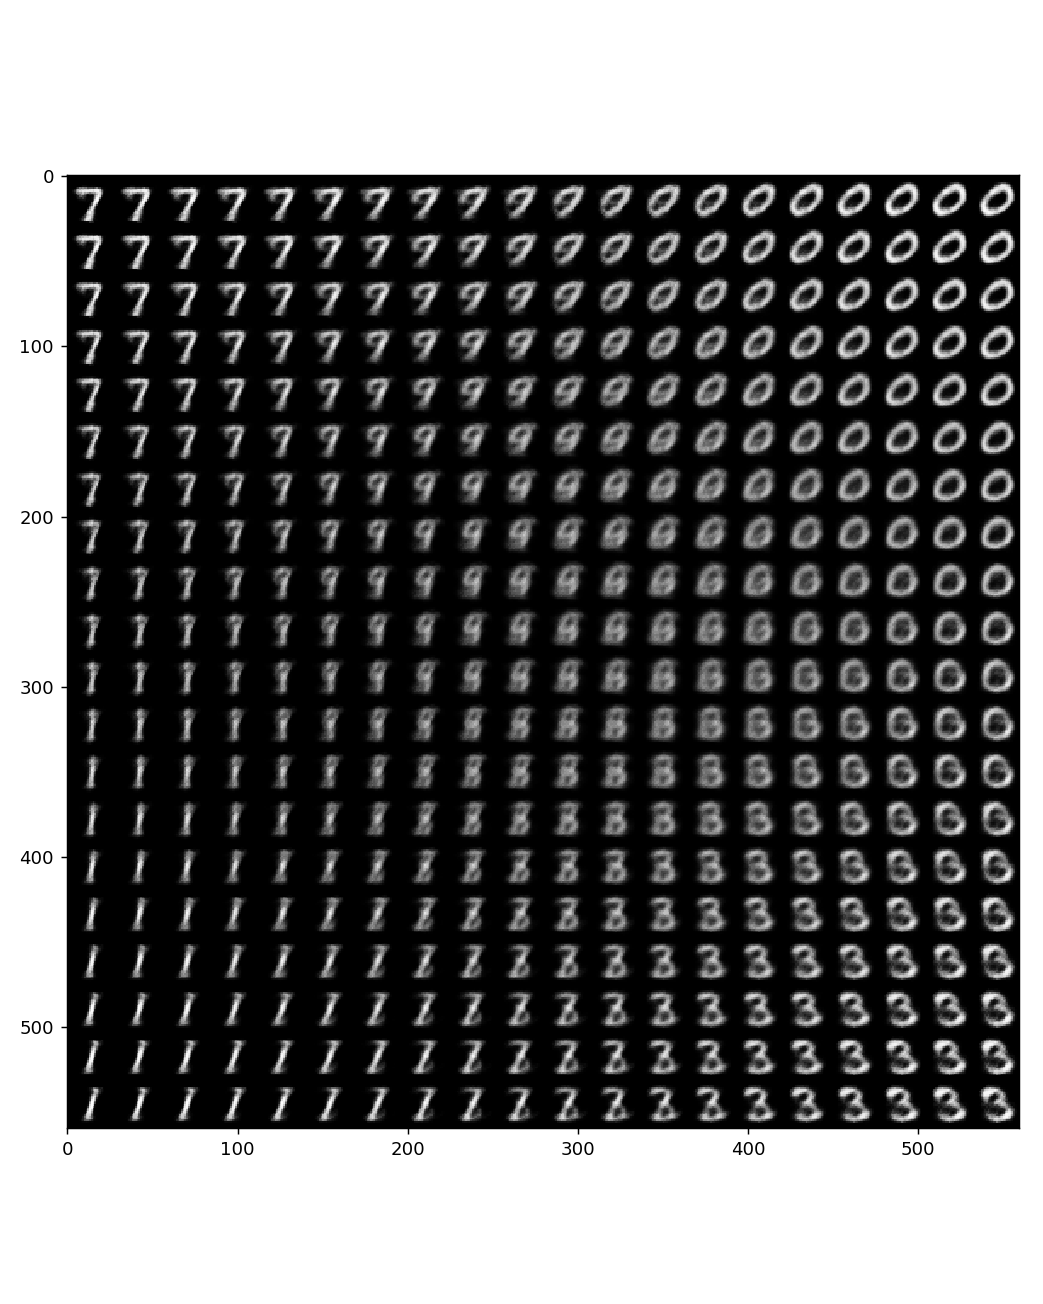

In [9]:
check_point_file = "model/vae2.ckpt"
d = np.zeros([batch_size, 2],dtype='float32')

nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((28*ny, 28*nx))
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, check_point_file)
    
    for i, yi in enumerate(x_values):
        for j, xi in enumerate(y_values):
            z_mu = np.array([[xi, yi]])
            d[0] = z_mu
            x_mean = sess.run(x_rec, feed_dict={z: d})
            canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()

One of the obvious problems with this approach, is that the reconstruction cost and the "enforce normal distribution" cost seem to be working against each other. At least to some extent. Some research have been put into attempting to fix this issue, one of which resulted in Generative Adversarial Networks. 



# Generative Adversarial Networks
asasdads, describe the idea. To speed up things we do GAN on AutoEncoder. This, to some extent, outsmarts VAE if one can actually train the GAN, because it doesn't change the AE. 

https://arxiv.org/abs/1406.2661

Let $x_1,...,x_n\sim p_d$. Our goal is to recover the data distribution $p_d$. Given some input noise distribution $x\sim p_z$ we implicitely let $p_g$ be the probability distribution of $G(z)\sim p_g$ where $G$ is the generator function that takes input noise and generates points that ... .

I


such that we can generate points that follow the distribution. Explicit methods of modeling $p_d$ often fall short because $p_d$ often becomes intractable. The approach taken here is to implcitely have a generator function define a probability distribution $p_g$. 

$$ V(D, G) = E_{x\sim p_x}[\log D(x)]+E_{z\sim p_z}[\log 1-D(G(z))]$$

<b>Proposition: </b>For fixed $G$ the optimal discriminator $D^*=\text{arg}\;\text{max}_D V(D, G)$ is $\frac{p_d(x)}{p_d(x)+p_g(x)}$.<br>
<i>Proof: </i><br>
The idea is to rewrite the value function $V(D, G)$ into something we can differentiate wrt. $D$ and solve for equal 0. Let us for now consider the discrete case of random variables $x,z$

$$
\begin{align}
V(D, G)&=E_{x\sim p_x}[\log D(x)]+E_{z\sim p_z}[\log (1-D(G(z)))]\\
&= \sum_x p_x(x) \log D(x) + \sum_z p_z(z) \log (1-D(G(z)))
\end{align}
$$

We now want to change the second sum from $z$ to $G(z)=x$. What should we write instead of $p_z(z)$? If we wrote $p_g(x)=p_g(G(z))$ this could be more than $p_z(z)$ because there might be multiple $z$ or no $z$ such that $G(z)=x$. If $G(z)$ we let the discriminator "win" and not consider the error. If multiple $z$ gives $G(z)=x$ the probability of $p_g(G(z))=p_z(z_1)+...+p_z(z_k)$ but $D(G(z_i))$ will all be equal, so the sum will be the same. This thus gives us

$$
\begin{align}
&= \sum_x p_x(x) \log D(x) + \sum_x p_g(x) \log (1-D(x))
\end{align}
$$

Remember we want to find the $D$ that minimizes the above sum. To do this we differentiate the sum with respect to $D(x)$ (why can we consider only one point instead of the entire sum?

$$p_x(x) \log D(x) + \sum_x p_g(x) \log (1-D(x)) $$

...

This concludes the proof. 

<b>Theorem: </b>The minimal value of $V(D, G)$ is obtained if and only if $p_d=p_g$. <br>
<i>Proof</i><br>


Describe game between them, prove that in unrealistic setting they converge. 

Go through the Math, define Nash Equilibrium

*In game theory, the Nash equilibrium, named after American mathematician John Forbes Nash Jr., is a solution concept of a non-cooperative game involving two or more players in which each player is assumed to know the equilibrium strategies of the other players, and no player has anything to gain by changing only his own strategy.*

Zero-sum Game: Alice' winnings is exactly Bobs loss. 

In [ ]:
#encode data

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, model_name_autoenc)
    print("Model restored.")
    
    enc_data = sess.run(enc_X, feed_dict={X: mnist.train.images[:50000]})
    print("Data encoded: ", enc_data.shape)
    h = enc_data.shape[0]
    rec_data = sess.run(dec, feed_dict={L: enc_data})
    print("Data decoded: ", rec_data.shape)
    
    plt.figure(figsize=(4, 4))        
    plt.imshow(rec_data[0].reshape(28, 28),  origin="upper", cmap="gray", aspect='auto')
    plt.tight_layout()
    print("Latent dim is: ", h)
    
    

In [ ]:
# Interactive Plotting
%matplotlib notebook 

# constants
train_steps = 50000
learning_rate = 0.01

# TODO:: LOAD AUTOENCODER !!.

model_name = "gan_" + str(time.time()) + ".ckpt"

d = h # input dim is output of autoencoder

# Noise distribution input
Z = tf.placeholder(tf.float32, shape=(None, d))
enc_data = tf.placeholder(tf.float32, shape=(None, d))

# architecture; just make simple feed forward
w_gen = tf.Variable(var_init( [d, d] ))
b_gen = tf.Variable(var_init( [d] ))

w_disc = tf.Variable(var_init( [d, 1] ))
b_disc = tf.Variable(var_init( [1] ))

gen = tf.nn.sigmoid(tf.matmul(Z, w_gen) + b_gen)

disc_real = tf.nn.sigmoid(tf.matmul(enc_data, w_disc) + b_disc) # sigmoid for prob.
disc_fake = tf.nn.sigmoid(tf.matmul(Z, w_disc) + b_disc)

disc_obj  = -tf.reduce_mean(tf.log(disc_real) + tf.log(1-disc_fake)) 
gen_obj = -tf.reduce_mean(tf.log(disc_fake))

gen_loss  = tf.train.AdamOptimizer(learning_rate).minimize(gen_obj)
disc_loss = tf.train.AdamOptimizer(learning_rate).minimize(disc_obj)

init = tf.global_variables_initializer()

# initialize interactive plotting
fig, (ax_train, ax_score, ax_done) = plt.subplots(1, 3, figsize=(12,4)) 
fig.tight_layout()
ax_train.axis("off")
ax_done.axis("off")
ax_score.set_xlim(0, train_steps)
visualize, _ = mnist.test.next_batch(4) 
loss_vals_D = []
loss_vals_G = []

#fig2, ax_noise = plt.subplots(1, 1, figsize=(12,4))  ## draw random noise a
with tf.Session() as sess:
    
    # Initialize all variables
    sess.run(init)
    
    # Load autoencoder 
    saver.restore(sess, model_name)  

    # Visualize noise
    visualize_noise = np.random.normal(0.0, 1.0, size=(100, d)) 

    for i in range(train_steps):
        x_data, _ = mnist.train.next_batch(batch_size)

        enc_x_data = sess.run(enc_X, feed_dict={X: x_data})
        
        # TODO: Consider larger variance
        noise = np.random.normal(0.0, 1.0, size=(batch_size, d)) 
        
        _, d_cost = sess.run([disc_loss, disc_obj], feed_dict={enc_data: enc_x_data, Z: noise}) # names
        _, g_cost = sess.run([gen_loss, gen_obj], feed_dict={Z: noise})
        
        loss_vals_D.append(d_cost)
        loss_vals_G.append(g_cost)
        
        
        if i % 1000 == 0: 
            #d_cost, g_cost = sess.run([disc_obj, gen_obj], feed_dict={enc_data: enc_x_data, Z: noise})
            sys.stdout.write("\rStep: %i\tDisc Loss: %f\tGen Loss: %f" % (i, d_cost, g_cost))
            sys.stdout.flush()
            
            ax_score.plot(loss_vals_D, color='b') # add title
            ax_score.plot(loss_vals_G, color='g') # add title
            
            latent = sess.run(gen, feed_dict={Z: noise})
            gen_images   = sess.run(dec, feed_dict={L: latent})

            images = np.empty((28 * 10, 28 * 10)) # add 2px space in between?

            for i in range(10):
                for j in range(10):
                    current_image = j + i*10

                    gen_image   = gen_images[current_image].reshape([28, 28])
                    images[i * 28: (i + 1) * 28, j * 28 :(j + 1) * 28] = gen_image
            
            ax_train.imshow(images, origin="upper", cmap="gray", aspect='auto')
            fig.canvas.draw()

    
    # save model
    saver.save(sess, model_name_gan)
    
    noise = np.random.normal(0.0, 1.0, size=(100, d)) 
    latent = sess.run(gen, feed_dict={Z: noise})
    gen_images   = sess.run(dec, feed_dict={L: latent})
        
    images = np.empty((28 * 10, 28 * 10)) # add 2px space in between?
    
    for i in range(10):
        for j in range(10):
            current_image = j + i*10
            
            gen_image   = gen_images[current_image].reshape([28, 28])
            images[i * 28: (i + 1) * 28, j * 28 :(j + 1) * 28] = gen_image
            
            
    plt.imshow(images, origin="upper", cmap="gray")
    plt.show()

# GAN + VAE + Feed Forward Network
Use both guys to generate numbers and have feed forward network try to classify them. Which generated data is the feed forward classifier most confident with?

In [ ]:
# load VAE50, gen 4x4 images

# load GAN, gen 4x4 images


# display and picture feed_forward guess of what the image is. 




# Open Problems

## Estimate KL Divergence of data distribution and generators implicit distirbution
Just estimating the probability of each data point would be interesting. Ideas: Box using random boxes/LCS, consider the derivative of the generated point with respect to the input to estimate probability as size of input that maps to point. 

$$ D_{kl}(p\mid\mid g)=\sum_x p(x)\log \left(\frac{p(x)}{g(x)}\right)$$

If we were to consider images of say $d=28\times 28$ the data space $X$ would consist of $|RGB|^{784}$. Full HD images would similarly be $|RBG|^{1920*1080}$. It thus seems intractable to compute the $KL$-divergence directly. The hope is that by sampling $D_{test}=x_1,..,x_n\sim p_{d}$ and $z_1,...,z_n\sim p_g$ we can estimate $p_i(y)$ for $i=d,g$ and $y=x,z$ and thus estimate $D_{kl}(p \mid\mid g)$. It is important to emphasize that the $x's$ should not be used during training/construction of $p_g$. 

If $G$ is a neural network $G: Z\rightarrow X$ the probability $p_g(x)=\frac{|\{z: G(z)=x\}|}{|Z|}$. It thus suffices to estimate $|\{ x: G(z)=x\}$. One way of doing this, would be to estimate how much $x$ change if $z$ change. If this is near zero, it means $|\{z: G(z)=x\}|$ is large, and conversely if it is large it must be small. Because $G$ is a neural network we can use backpropagation to compute $\frac{d G(z)}{d z}$. It thus suffices to prove that 

$$ |\{z: G(z)=x\}|\approx f( \frac{d G(z)}{z} )$$

For some inverse function $f$. One problem with this approach is the interpretation of the derivative being with respect to euclidean distance. It might make more sence semantically to take the $NN$-derivative of $G(z)$ with respect to $z$. 

The problem here seems to be that the inputs that map to the same $x$ can be very located different places in the latent space. If they were all located close (which seems to be the case with VAE)? If you picture the latent space this seems to be the case. In other words, this should then allow us to say "what is the probability of generating this box in X space, well, this must be the fractional size of the inputs in Z space that generate X; these can be computed by doing ...". 
  It might be that we can modify neural networks to compute such that Z space behaves nicely. 


## Prove VAE is worse than AutoEncoder + GAN


## Use Generative Models in a semi supervised sense on CIFAR10 and try to beat performance on highscore. 


## Convergence of GANS. 

# Other interesting topics
Use of GANS in imitation learning / reinforcement learning. 




In [ ]:
 It 